# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [22]:
# all imports and magic commands
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Molly\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Molly\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [23]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [24]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
#     if (not test): # fit_transform()
#         hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
#         X_hv = hv.fit_transform(movie_data.review)
#         fitted_transformations.append(hv)
#         print("Shape of HashingVectorizer X:")
#         print(X_hv.shape)
#     else: # transform() 
#         X_hv = fitted_transformations[0].transform(movie_data.review)
#         print("Shape of HashingVectorizer X:")
#         print(X_hv.shape)

    nltk.download('stopwords')
    stop_words = set(nltk.corpus.stopwords.words('english'))
    
#     class LemmaTokenizer:
#         def __init__(self):
#             self.wnl = WordNetLemmatizer()
#         def __call__(self, doc):
#             return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
#     vect = CountVectorizer(tokenizer=LemmaTokenizer())  

    if (not test): # fit_transform()
        cv = CountVectorizer(ngram_range=(1, 2),token_pattern=r'\b\w+\b', min_df=1)
        X_cv = cv.fit_transform(movie_data.review)
        fitted_transformations.append(cv)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)
    else: # transform() 
        X_cv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_cv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_cv)
        
 
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
   
    caps_re = '([A-Z]){2,}'
    
    movie_data['quotes'] = movie_data['review'].str.count('\"')
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['exclaim_dbl'] = movie_data['review'].str.count("\!?")
    movie_data['caps'] = movie_data['review'].str.count('([A-Z]){5,}')
    movie_data['questions'] = movie_data['review'].str.count('(\?)')
    movie_data['questions_2'] = len(re.findall('(\?){3,}', str(movie_data['review'])))
    movie_data['exclaim'] = len(re.findall('(\!){3,}', str(movie_data['review'])))
    movie_data['quotes_count'] = movie_data['review'].str.split('\"').str.len()
    movie_data['exclaim_count'] = movie_data['review'].str.split('\!').str.len()
    movie_data['question_count'] = movie_data['review'].str.split('\?').str.len()
    movie_data['caps_count'] = len(re.findall(caps_re, str(movie_data['review'])))

    


    X_quant_features = movie_data[["quotes_count", "caps_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [25]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=25)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Molly\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Shape of CountVectorizer X:
(25000, 1455074)
Look at a few rows of the new quantitative features: 
   quotes_count  caps_count
0             1           0
1             9           0
2             1           0
3             7           0
4             7           0
5             1           0
6             1           0
7             1           0
8             1           0
9             5           0
Size of combined bag of words and new quantitative variables matrix:
(25000, 1455076)
(25000, 1455076)
Shape of X_train and X_test:
(20000, 1455076)
(5000, 1455076)
Shape of y_train and y_test:
(20000,)
(5000,)
Shape of X_raw_train and X_raw_test:
(20000, 14)
(5000, 14)
SUCCESS!
Number of fits stored in `fitted_transformations` list: 
3


# Fit (and tune) Various Models

### MODEL: LinearSVC C=1

In [128]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import LinearSVC
svc1 = LinearSVC(C=1)

svc1.fit(X_train, y_train)


svc_performance_train_1 = BinaryClassificationPerformance(svc1.predict(X_train), y_train, 'svc_train_c=1')
svc_performance_train_1.compute_measures()
print(svc_performance_train_1.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svc_train_c=1'}


### MODEL: LinearSVC C=.000001

In [129]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import LinearSVC
svc2 = LinearSVC(C=.000001, max_iter=10000)

svc2.fit(X_train, y_train)


svc_performance_train_2 = BinaryClassificationPerformance(svc2.predict(X_train), y_train, 'svc_train_c=.000001')
svc_performance_train_2.compute_measures()
print(svc_performance_train_2.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svc_train_c=.000001'}


### MODEL: LinearSVC C=.0000001

In [131]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import LinearSVC
svc3 = LinearSVC(C=.0000001, max_iter=10000)

svc3.fit(X_train, y_train)


svc_performance_train_3 = BinaryClassificationPerformance(svc3.predict(X_train), y_train, 'svc_train_c=.0000001')
svc_performance_train_3.compute_measures()
print(svc_performance_train_3.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9973, 'TN': 10022, 'FP': 1, 'FN': 4, 'Accuracy': 0.99975, 'Precision': 0.9998997393222379, 'Recall': 0.9995990778791219, 'desc': 'svc_train_c=.0000001'}


### MODEL: LinearSVC C=.00000001

In [132]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import LinearSVC
svc4 = LinearSVC(C=.00000001, max_iter=10000)

svc4.fit(X_train, y_train)


svc_performance_train_4 = BinaryClassificationPerformance(svc4.predict(X_train), y_train, 'svc_train_c=.00000001')
svc_performance_train_4.compute_measures()
print(svc_performance_train_4.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9962, 'TN': 10022, 'FP': 1, 'FN': 15, 'Accuracy': 0.9992, 'Precision': 0.9998996286259159, 'Recall': 0.9984965420467075, 'desc': 'svc_train_c=.00000001'}


### MODEL: LinearSVC C=.000000001

In [133]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import LinearSVC
svc5 = LinearSVC(C=.000000001, max_iter=10000)

svc5.fit(X_train, y_train)


svc_performance_train_5 = BinaryClassificationPerformance(svc5.predict(X_train), y_train, 'svc_train_c=.000000001')
svc_performance_train_5.compute_measures()
print(svc_performance_train_5.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9960, 'TN': 10022, 'FP': 1, 'FN': 17, 'Accuracy': 0.9991, 'Precision': 0.9998996084730448, 'Recall': 0.9982960809862684, 'desc': 'svc_train_c=.000000001'}


### MODEL: LinearSVC C=.0000000001

In [134]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import LinearSVC
svc6 = LinearSVC(C=.0000000001, max_iter=10000)

svc6.fit(X_train, y_train)


svc_performance_train_6 = BinaryClassificationPerformance(svc6.predict(X_train), y_train, 'svc_train_c=.0000000001')
svc_performance_train_6.compute_measures()
print(svc_performance_train_6.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9960, 'TN': 10022, 'FP': 1, 'FN': 17, 'Accuracy': 0.9991, 'Precision': 0.9998996084730448, 'Recall': 0.9982960809862684, 'desc': 'svc_train_c=.0000000001'}


### MODEL: LinearSVC C=.00000000001

In [135]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import LinearSVC
svc7 = LinearSVC(C=.00000000001, max_iter=10000)

svc7.fit(X_train, y_train)


svc_performance_train_7 = BinaryClassificationPerformance(svc7.predict(X_train), y_train, 'svc_train_c=.00000000001')
svc_performance_train_7.compute_measures()
print(svc_performance_train_7.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9960, 'TN': 10022, 'FP': 1, 'FN': 17, 'Accuracy': 0.9991, 'Precision': 0.9998996084730448, 'Recall': 0.9982960809862684, 'desc': 'svc_train_c=.00000000001'}


### ROC Plot Test

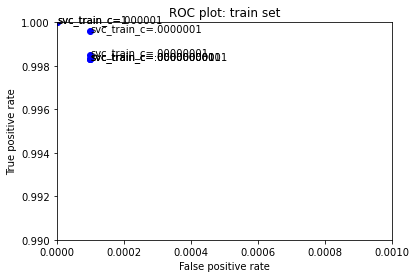

In [156]:
fits = [svc_performance_train_7, svc_performance_train_6, svc_performance_train_5, svc_performance_train_4, svc_performance_train_3, svc_performance_train_2, svc_performance_train_1]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.001, 0.99, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [82]:
svc_predictions = svc.predict(X_train)

### let's look at some false positives:

In [18]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(svc_predictions)):
    if (svc_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: LinearSVC C=1

In [137]:
svc_performance_test_1 = BinaryClassificationPerformance(svc1.predict(X_test), y_test, 'svc_test_c=1')
svc_performance_test_1.compute_measures()
print(svc_performance_test_1.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2309, 'TN': 2240, 'FP': 237, 'FN': 214, 'Accuracy': 0.9098, 'Precision': 0.9069128043990573, 'Recall': 0.9151803408640508, 'desc': 'svc_test_c=1'}


### MODEL: LinearSVC C=.000001

In [138]:
svc_performance_test_2 = BinaryClassificationPerformance(svc2.predict(X_test), y_test, 'svc_test_c=.000001')
svc_performance_test_2.compute_measures()
print(svc_performance_test_2.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2278, 'TN': 2257, 'FP': 220, 'FN': 245, 'Accuracy': 0.907, 'Precision': 0.911929543634908, 'Recall': 0.902893380895759, 'desc': 'svc_test_c=.000001'}


### MODEL: LinearSVC C=.0000001

In [139]:
svc_performance_test_3 = BinaryClassificationPerformance(svc3.predict(X_test), y_test, 'svc_test_c=.0000001')
svc_performance_test_3.compute_measures()
print(svc_performance_test_3.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2171, 'TN': 2282, 'FP': 195, 'FN': 352, 'Accuracy': 0.8906, 'Precision': 0.9175824175824175, 'Recall': 0.8604835513277844, 'desc': 'svc_test_c=.0000001'}


### MODEL: LinearSVC C=.00000001

In [140]:
svc_performance_test_4 = BinaryClassificationPerformance(svc4.predict(X_test), y_test, 'svc_test_c=.00000001')
svc_performance_test_4.compute_measures()
print(svc_performance_test_4.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2124, 'TN': 2272, 'FP': 205, 'FN': 399, 'Accuracy': 0.8792, 'Precision': 0.9119793902962645, 'Recall': 0.8418549346016647, 'desc': 'svc_test_c=.00000001'}


### MODEL: LinearSVC C=.000000001

In [141]:
svc_performance_test_5 = BinaryClassificationPerformance(svc5.predict(X_test), y_test, 'svc_test_c=.000000001')
svc_performance_test_5.compute_measures()
print(svc_performance_test_5.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2126, 'TN': 2269, 'FP': 208, 'FN': 397, 'Accuracy': 0.879, 'Precision': 0.9108826049700086, 'Recall': 0.8426476416963932, 'desc': 'svc_test_c=.000000001'}


### MODEL: LinearSVC C=.0000000001

In [142]:
svc_performance_test_6 = BinaryClassificationPerformance(svc6.predict(X_test), y_test, 'svc_test_c=.0000000001')
svc_performance_test_6.compute_measures()
print(svc_performance_test_6.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2125, 'TN': 2269, 'FP': 208, 'FN': 398, 'Accuracy': 0.8788, 'Precision': 0.9108444063437634, 'Recall': 0.8422512881490289, 'desc': 'svc_test_c=.0000000001'}


### MODEL: LinearSVC C=.00000000001

In [143]:
svc_performance_test_7 = BinaryClassificationPerformance(svc7.predict(X_test), y_test, 'svc_test_c=.00000000001')
svc_performance_test_7.compute_measures()
print(svc_performance_test_7.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2125, 'TN': 2269, 'FP': 208, 'FN': 398, 'Accuracy': 0.8788, 'Precision': 0.9108444063437634, 'Recall': 0.8422512881490289, 'desc': 'svc_test_c=.00000000001'}


### ROC plot to compare performance of various models and fits

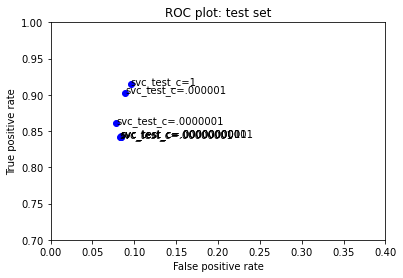

In [155]:

fits = [svc_performance_test_7, svc_performance_test_6, svc_performance_test_5, svc_performance_test_4, svc_performance_test_3, svc_performance_test_2, svc_performance_test_1]

for fit in fits:
#     print (fit.performance_measures)
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, .4 , 0.7, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [33]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=25, test=True)

print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Molly\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Shape of CountVectorizer X:
(25000, 1455074)
Look at a few rows of the new quantitative features: 
   quotes_count  caps_count
0             1           0
1             1           0
2             3           0
3             1           0
4             1           0
5             1           0
6             1           0
7             1           0
8             1           0
9             3           0
Size of combined bag of words and new quantitative variables matrix:
(25000, 1455076)
(25000, 1455076)
Shape of X_test for submission:
(25000, 1455076)
SUCCESS!
Number of rows in the submission test set (should be 25,000): 


---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [35]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49704


In [36]:
raw_data.head()

,id,review,quotes,word_count,exclaim_dbl,caps,questions,questions_2,exclaim,quotes_count,exclaim_count,question_count,caps_count
0,12311_10,Naturally in a film who's main themes are of m...,0,131,770,0,0,0,0,1,1,1,0
1,8348_2,This movie is a disaster within a disaster fil...,0,169,897,0,0,0,0,1,2,1,0
2,5828_4,"All in all, this is a movie for kids. We saw i...",2,176,989,0,0,0,0,3,1,1,0
3,7186_2,Afraid of the Dark left me with the impression...,0,112,658,0,0,0,0,1,1,1,0
4,12128_7,A very accurate depiction of small time mob li...,0,133,763,0,0,0,0,1,1,1,0


In [37]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [38]:
my_submission.shape

(25000, 2)

In [39]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission_MollyCook.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation